
# Image Classification with CNN
---
---
# ⭐'파일 - 드라이브에 사본 저장' 버튼을 눌러 개인 드라이브에 사본을 생성한 뒤 수정⭐
---
---
- 현재 Ver의 소개
> - CPU 처리 (현재 처리 방법)
 - GPU 처리 : https://tutorials.pytorch.kr/beginner/basics/buildmodel_tutorial.html 참조
 - Colab GPU 세팅 : https://hichoe95.tistory.com/29 참조

- 현재 Model 소개
> - LeNet-5 :   
Yann LeCun 연구팀이 1998년에 LeNet-5를 발표했다. LeNet-5에서는 입력 이미지의 크기가 커졌고, Fully connected layer가 추가되었다.   
LeNet-1에서는 16x16로 이미지를 줄이고 28x28 중앙에 위치시켰지만, LeNet-5에서는 28x28 이미지를 32x32의 중앙에 위치시켰다. 이처럼 LeNet-5에서 LeNet-1 보다 더 큰 이미지를 사용했기 때문에 이미지의 Detail한 부분까지 고려하여 성능이 더 높아진 부분도 있다.   
또한, LeNet-5는 Network가 크기 때문에 Parameter 수는 6만개에 달한다 (DNN: 약 12만개, LeNet-1: 약 3천개).   

- CIFAR10
> - 내용 : 10가지 범주를 가진 32X32 픽셀의 컬러 이미지 데이터셋
 - 범주 : [비행기, 자동차, 새, 고양이, 사슴, 개, 개구리, 말, 배, 트럭]    
 - train : test = 50k : 10k인 총 60k개의 이미지 데이터

- 전체 흐름
> 0. 패키지 로딩 & 환경 설정 
 1. 데이터 불러오기
 2. 모형 구축
 3. 모형 학습
 4. Test 데이터 예측



- 현재 모형

|Order|Input data struct|Layer|Filter|Stride|Output data struct|
|:-:|:-|:-|:-:|:-:|:-|
|0|32 X 32 X 3|Input data|
|1|32 X 32 X 3|Conv1 + ReLU|5 X 5|1|28 X 28 X 6|
|2|28 X 28 X 6|MaxPool|2 X 2|2|14 X 14 X 6|
|3|14 X 14 X 6|Conv2 + ReLU|5 X 5|1|10 X 10 X 16|
|4|10 X 10 X 16|MaxPool|2 X 2|2|5 X 5 X 16|
|5|5 X 5 X 16|Flatten|||400 X 1|
|6|400 X 1|FC + ReLU|||120 X 1|
|7|120 X 1|FC + ReLU|||84 X 1|
|8|84 X 1|FC|||10 X 1|
|9||Output data|||10 X 1|

# 0. 패키지 로딩 & 환경 설정

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn #deep learning model에 필요한 모듈이 모아져있는 패키지
import torch.nn.functional as F #nn과 같은 모듈이 모아져 있지만 함수의 input으로 반드시 연산이 되어야 하는 값을 받음.
import torch.optim as optim #학습에 관련된 optimizing method가 있는 패키지
import matplotlib.pyplot as plt #시각화 패키지
import numpy as np

In [4]:
print("PyTorch version: {}".format(torch.__version__))
print("CUDA version: {}".format(torch.version.cuda))

PyTorch version: 1.11.0
CUDA version: 11.3


In [2]:
# 고정
torch.manual_seed(42)

# 1. 데이터 불러오기

In [3]:
transform = transforms.Compose( 
    [transforms.ToTensor(), #이미지가 0~1사이 값으로 변경 
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)


####여러단계로 데이터를 변환해야하는 경우 transforms.Compose()에서 여러단계를 한번에 묶을 수 있음
####ToTensor를 통해 텐서형태로 이미지를 변환함(numpy배열, PIL이미지 형식인 경우 ToTensor를 사용하여 텐서형식으로 변환
####normalize에서 평균,표준편차 사용하여 이미지를 정규화함->텐서를 가져와 평균 및 표준 편차로 정규화
####평균표준편차가 3개인 이유는 3개의 채널마다 평균, 표준편차를 적용해주어야하기 떄문이다.
####후에 transform모듈을 활용하여 이미지 데이터를 불러올때 텐서형태로 변환, 데이터 정규화를 동시에 할 수 있다.

In [5]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform) 
#trainset을 불러올때, transpose 시켜준다->텐서로 변환 및 정규화

Files already downloaded and verified


In [6]:
type(trainset)

torchvision.datasets.cifar.CIFAR10

In [8]:
print(trainset)

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )


In [9]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)

In [10]:
print(trainloader)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


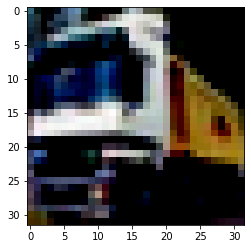

In [12]:
#######sample data
sample=trainset[1][0].numpy()
sample=np.transpose(sample,(1,2,0))
plt.imshow(sample)

In [13]:
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

Files already downloaded and verified


In [17]:
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False, num_workers=2) 
#test data는 shuffle X

In [18]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck') #Cifar dataset에 이미지 데이터 범주별로 입력

In [19]:
def imshow(img) :
  img = img/2+0.5 #unnormalize
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.show()

In [20]:
dataiter = iter(trainloader)
images, labels = dataiter.next()
#iter() 함수로 trainloader에 들어있는 이미지와 라벨을 꺼낼 수 있는 객체를 생성함
#next() 함수로 이미지와 데이터 라벨을 꺼내옴

In [26]:
print(images) #batch size가 4이기 때문에 4개에 이미지에 대한 Tesnsor 반환
print(labels) #4개의 이미지에 대한 라벨값 추출

tensor([[[[-0.1529, -0.1373, -0.2392,  ..., -0.1529, -0.3098, -0.3961],
          [-0.7255, -0.4275, -0.3098,  ..., -0.3176, -0.1922, -0.2627],
          [-0.7176, -0.9294, -0.7255,  ..., -0.5451, -0.3020, -0.3176],
          ...,
          [-0.1765, -0.2471, -0.3098,  ..., -0.1373, -0.0824, -0.1843],
          [-0.0824, -0.3882, -0.2941,  ..., -0.0902, -0.0275, -0.1765],
          [-0.0980, -0.1686, -0.0353,  ..., -0.0745, -0.4353, -0.3882]],

         [[ 0.3176,  0.3961,  0.3333,  ...,  0.1059, -0.0353, -0.0980],
          [-0.2784,  0.0588,  0.1922,  ..., -0.0275,  0.0980,  0.0353],
          [-0.2392, -0.4588, -0.3020,  ..., -0.2235,  0.0118, -0.0196],
          ...,
          [ 0.5137,  0.4353,  0.3725,  ...,  0.3412,  0.3804,  0.2627],
          [ 0.5216,  0.1922,  0.2706,  ...,  0.3725,  0.4196,  0.2549],
          [ 0.4902,  0.4275,  0.5686,  ...,  0.3725, -0.0588,  0.0353]],

         [[-0.4510, -0.4275, -0.5373,  ..., -0.4745, -0.6471, -0.7412],
          [-0.8118, -0.6078, -

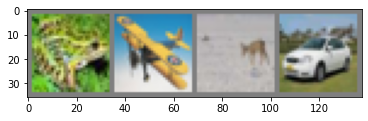

GroundTruth:   frog plane  deer   car


In [27]:
imshow(torchvision.utils.make_grid(images)) #여러 이미지를 한 번에 출력
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4))) #이미지와 실제 라벨값 추출

# 2. 모형 구축

In [28]:
class Net(nn.Module): #신경망을 정의할때 nn.Module을 활용하여 만드는 것이 일반적
    def __init__(self): # __init__에서 함수를 정의함
        super(Net, self).__init__() #super()를 통해 클래스 상속, super(모델명,self).__init__을 통해 nn.Module을 실행시키는 코드
        self.conv1 = nn.Conv2d(3, 6, 5) #컨볼루션 레이어->학습가능한 필터로 이루어진 부분, 필터란:이미지의 특징을 찿아내기 위한 공용파라미터
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)#conv2d(input,output,kernel_size)
        self.fc1 = nn.Linear(16 * 5 * 5, 120) #nn.Linear(input feature, output feature),선형변환을 적용하는 모듈
        self.fc2 = nn.Linear(120, 84) 
        self.fc3 = nn.Linear(84, 10)
        
    def forward(self, x): #forward에서 모델이 어떻게 학습할지 코딩
        x = self.pool(F.relu(self.conv1(x))) #covolution1+relu함수 적용+maxpool=14x14x6
        x = self.pool(F.relu(self.conv2(x))) #convolution2+relu+maxpool=5x5x16
        x = x.view(-1, 16 * 5 * 5) # x = torch.flatten(x, 1) #3차원->1차원으로 평탄화작업
        x = F.relu(self.fc1(x)) #fully-connected층(1차원변환데이터가 각 범주에 속할확률)+Relu(activation function=분류를위한 데이터 특징강조,비선형) 
        x = F.relu(self.fc2(x)) #fully-connected층(1차원변환데이터가 각 범주에속학확률)+Relu(activation function=분류를 위한 데이터 특장강조,비선형)
        x = self.fc3(x)
        return x
        
net = Net() #여기에 

In [29]:
criterion = nn.CrossEntropyLoss() #손실함수->예측값과 실제값 비교
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9) 
#optimization gradient(기울기)구해서 가중치 값을 변환시켜
#최적의 weight값을 찿는다.
#SGD의 원리는 loss함수의 미분을 이용하여 loss를 줄이는것 gradient가 -가 되도록 값을 이동시키면 언젠가 최소값을 찿을 수 있다는 아이디어
#learning rate=미분값을 얼만큼 이동시킬지->조금씩해야함
#momentum=이전 가중치의 업데이트값의 일정 비율을 반영하는 매개변수

# 3. 모형 학습

In [33]:
for epoch in range(2): # 여러번 데이터셋 반복하기

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0): #enumerate 인덱스와 원소 tuple로 반환
        # 입력값을 얻습니다. 데이타는 [입력값, 레이블]의 목록입니다.
        inputs, labels = data
        
        # 매개변수 변화도를 0으로 만듭니다.
        optimizer.zero_grad() #한번 학습이 완료되면, gradient를 0으로 만들어주어야함, 초기화하지 않을시 의도한 방향과 다른방향으로 학습할 가능성
        
        # 순전파 + 역전파 + 최적화
        outputs = net(inputs) #CNN모델 적용부분
        loss = criterion(outputs, labels) #loss계산
        loss.backward() #backpropogation에서 gradient를 계산, loss값들을 가중치들에 대해서 미분 ex)x가 변화했을때 함수g가 얼마나 변하는지 알 수 있음
        optimizer.step() #업데이트할 parameter와 learning rate 들을 step() method를 통해 업데이트 한다
        
        # 통계 추력
        running_loss += loss.item()
        if i % 2000 == 1999: # 매 2000번 미니배치마다 출력하기
            print('[%d, %5d] loss: %.3f' %
                  (epoch+1, i+1, running_loss / 2000))
            running_loss =0.0
            
print('Finished Training')

PATH = './cifar_net.pth' #저장경로
torch.save(net.state_dict(), PATH) #저장하기

[1,  2000] loss: 0.987
[1,  4000] loss: 0.993
[1,  6000] loss: 0.987
[1,  8000] loss: 1.007
[1, 10000] loss: 1.002
[1, 12000] loss: 0.989
[2,  2000] loss: 0.995
[2,  4000] loss: 0.991
[2,  6000] loss: 1.004
[2,  8000] loss: 1.007
[2, 10000] loss: 0.973
[2, 12000] loss: 0.990
Finished Training


# 4. Test 데이터 예측

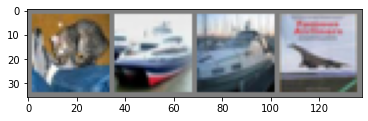

GroundTruth:    cat  ship  ship plane
Predicted :   ship   car  ship  ship


In [35]:
dataiter = iter(testloader)
images, labels = dataiter.next()
#iter() 함수로 trainloader에 들어있는 이미지와 라벨을 꺼낼 수 있는 객체를 생성함
#next() 함수로 이미지와 데이터 라벨을 꺼내옴
# 이미지 출력하기

imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

net = Net() #net초기화
net.load_state_dict(torch.load(PATH)) #train으로 학습한 모델의 파라미터 불러오기 (dictionary형태로 parameter정보가 포함되어있음)
outputs = net(images) #모델적용
_, predicted = torch.max(outputs, 1) #예측최대값과 최대값에 인데스를 튜플로 반환,행을 기준으로 최대값 찿음
print('Predicted : ', ' '.join('%5s' % classes[predicted[j]] for j in range(4)))

In [36]:
correct = 0
total = 0
with torch.no_grad(): #test예측할때는 gradient,context를 비활성화 시켜줌으로써 계산속도 향상시켜줌
    for data in testloader:
        images, labels = data
        outputs = net(images) #모델적용
        _, predicted = torch.max(outputs.data, 1) #행을 기준으로 최대값 찿음
        total += labels.size(0) #전체 10000개
        correct += (predicted == labels).sum().item() #예측값==실제값 카운트
        
print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))

Accuracy of the network on the 10000 test images: 60 %


In [ ]:
# class_correct = list(0. for i in range(10))
# class_total = list(0. for i in range(10))
# with torch.no_grad():
#     for data in testloader:
#         images, labels = data
#         outputs = net(images)
#         _, prediceted = torch.max(outputs, 1)
#         c = (predicted == labels).squeeze()
#         for i in range(4):
#             label = labels[i]
#             class_correct[label] += c[i].item()
#             class_total[label] += 1
            
# for i in range(10):
#     print('Accuract of %5s : %2d %%' %(classes[i], 100 * class_correct[i] / class_total[i]))

In [37]:
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images) #모델 적용
        _, predictions = torch.max(outputs, 1) #행기준으로 예측 최대값 찿음
        for label, prediction in zip(labels, predictions): #zip함수를 통해 (실제값,예측값)형태로 묶음
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.2f} %')

Accuracy for class: plane is 63.10 %
Accuracy for class: car   is 75.60 %
Accuracy for class: bird  is 39.40 %
Accuracy for class: cat   is 56.60 %
Accuracy for class: deer  is 39.30 %
Accuracy for class: dog   is 52.90 %
Accuracy for class: frog  is 63.60 %
Accuracy for class: horse is 59.40 %
Accuracy for class: ship  is 76.40 %
Accuracy for class: truck is 78.90 %
